## Dimensionality Reduction (DR) Techniques
Dimensionality reduction techniques uncovers the underlying structure of high-dimensional data.
Used to visualize clusters, denoise signals, and possibly prepare data for further ML analysis.

## Overview of PCA, MDS, t-SNE & UMAP

### Principal Component Analysis (PCA)
- A *linear* DR technique that projects data onto orthogonal axes (Principal Components or PCs) maximizing variance.
- PCA identifies directions (PC) where data vary the most, which explain the majority of variance using fewer dimensions.

### Multidimensional Scaling (MDS)
- A distance preserving DR method that is non-linear or linear depending on metric of choice.
- MDS reconstructs low-dimensional coordinates by trying to keep the original high-dimensional distance matrix intact.

### t-Distributed Stochastic Neighbor Embedding (t-SNE)
- Non-linear, stochastic DR method that preserves neighborhoods (local structure).
- t-SNE converts distances into probabilities to keep similar points near each other, with a heavy emphasis on local structure.

### Uniform Manifold Approximation and Projection (UMAP)
- Non-linear manifold learning DR method that tries to preserve both global and local structure.
- UMAP builds a graph of local relationships and optimizes low-dimensional projection while preserving manifold shape.

In [35]:
# install UMAP in same python environment if required (I was having problems)
#import sys
#!{sys.executable} -m pip install umap-learn

In [36]:
# Cell 1: Imports & helper functions
# import standard libs and ML tools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE, trustworthiness
import umap.umap_ as umap
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    accuracy_score,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import pairwise_distances
import warnings
warnings.filterwarnings("ignore")


In [37]:
# Cell 2: Helper functions & Defaults
# define reusable plotting functions and metric helpers

# Plot defaults
sns.set(style="whitegrid", context="notebook", font_scale=1.1)
plt.rcParams["figure.figsize"] = (8, 6)

# Helper: 2D scatter colored by labels
def plot_2d_embedding(emb, labels, title="", ax=None, palette="tab10"):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 5))
    sc = ax.scatter(emb[:, 0], emb[:, 1], c=labels, cmap=palette, s=10, alpha=0.9)
    ax.set_title(title)
    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")
    return ax

# Trustworthiness wrapper (sklearn's implementation)
def compute_trust(X, X_emb, n_neighbors=12):
    # trustworthiness returns float in (0,1], higher is better
    return trustworthiness(X, X_emb, n_neighbors=n_neighbors)

# KNN-preservation curve:
# for each k in ks, compute proportion of each point's k-nearest neighbors in original space
# that are kept in embedding's k-NN.
def knn_preservation_curve(X, X_emb, ks=(5,10,20)):
    D_orig = pairwise_distances(X)
    D_emb = pairwise_distances(X_emb)
    n = X.shape[0]
    # get neighbor indices excluding self
    idx_orig = np.argsort(D_orig, axis=1)[:, 1:]  # sorted ascending, drop self
    idx_emb = np.argsort(D_emb, axis=1)[:, 1:]
    results = {}
    for k in ks:
        # for each point compute intersection size
        inter_sizes = []
        for i in range(n):
            set_orig = set(idx_orig[i, :k])
            set_emb = set(idx_emb[i, :k])
            inter_sizes.append(len(set_orig & set_emb) / k)
        results[k] = np.mean(inter_sizes)
    return results


In [38]:
# Cell 2: Load dataset and Pre-processing
# Digits dataset has 64 features (8x8 images) and 1797 data points
# Scale features before PCA / t-SNE / UMAP

data = load_digits()
X = data.data  # shape (n_samples, 64)
y = data.target
print("X.shape:", X.shape, "Classes:", len(np.unique(y))) # Classes correspond to the 10 digits

# Standardize features (important for PCA & many manifold methods)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X.shape: (1797, 64) Classes: 10


Number of PCs required to reach ≥90% explained variance: 31


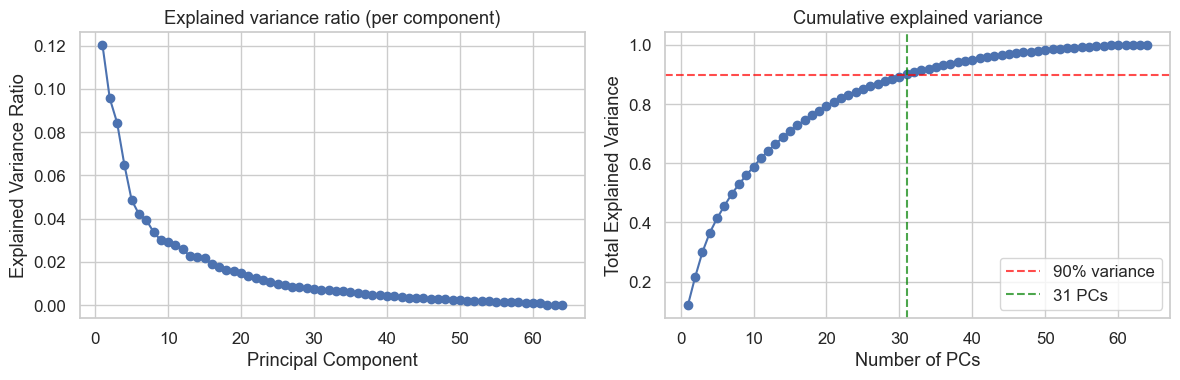

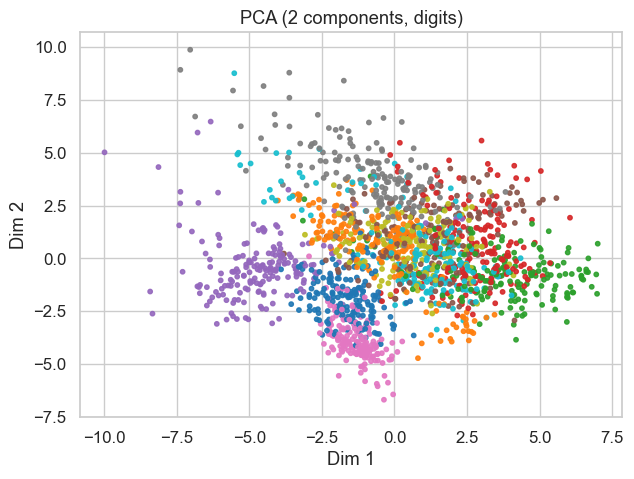

PCA reconstruction MSE with 2 components: 0.7473
PCA reconstruction MSE with 10 components: 0.3920
PCA reconstruction MSE with 30 components: 0.1018
PCA reconstruction MSE with 31 components: 0.0949
PCA reconstruction MSE with 35 components: 0.0703


In [39]:
# Cell 3: PCA
# Fit PCA
# Explore explained variance per component and plot clusters for PC1 vs PC2.

pca = PCA(n_components=64, random_state=101)
X_pca_full = pca.fit_transform(X_scaled)

# Screeplot / explained variance
explained = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained)

# Find number of PCs for 90% explained variance
threshold = 0.90 #SME or preconception-based; can also be derived using elbow-rule in Screeplot
n_pc_90 = np.argmax(cum_explained >= threshold) + 1 # +1 since PCs start from 0 like arrays
print(f"Number of PCs required to reach ≥90% explained variance: {n_pc_90}")

# Plotting
fig, ax = plt.subplots(1,2, figsize=(12,4))

# Plot individual explained variance
ax[0].plot(np.arange(1, len(explained)+1), explained, marker='o')
ax[0].set_title("Explained variance ratio (per component)")
ax[0].set_xlabel("Principal Component")
ax[0].set_ylabel("Explained Variance Ratio")

# Plot cumulative explained variance + horizontal and vertical line
ax[1].plot(np.arange(1, len(cum_explained)+1), cum_explained, marker='o')
ax[1].axhline(threshold, color='red', linestyle='--', alpha=0.7, label='90% variance')
ax[1].axvline(n_pc_90, color='green', linestyle='--', alpha=0.7, label=f'{n_pc_90} PCs')

ax[1].set_title("Cumulative explained variance")
ax[1].set_xlabel("Number of PCs")
ax[1].set_ylabel("Total Explained Variance")
ax[1].legend()

plt.tight_layout()
plt.show()

# Visualization: 2D projection of 1st 2 PCs
X_pca2 = PCA(n_components=2, random_state=101).fit_transform(X_scaled)
plot_2d_embedding(X_pca2, y, title="PCA (2 components, digits)")
plt.show()

# PCA reconstruction error - measures information loss
def pca_reconstruction_mse(X_scaled, n_components):
    p = PCA(n_components=n_components, random_state=0).fit(X_scaled)
    X_rec = p.inverse_transform(p.transform(X_scaled))
    return np.mean((X_scaled - X_rec)**2)

for k in [2, 10, 30, 31, 35]: # 31 PCs explain 90% of vaiance (my threshold of choice)
    print(f"PCA reconstruction MSE with {k} components: {pca_reconstruction_mse(X_scaled, k):.4f}")


MDS stress: 91778.0938


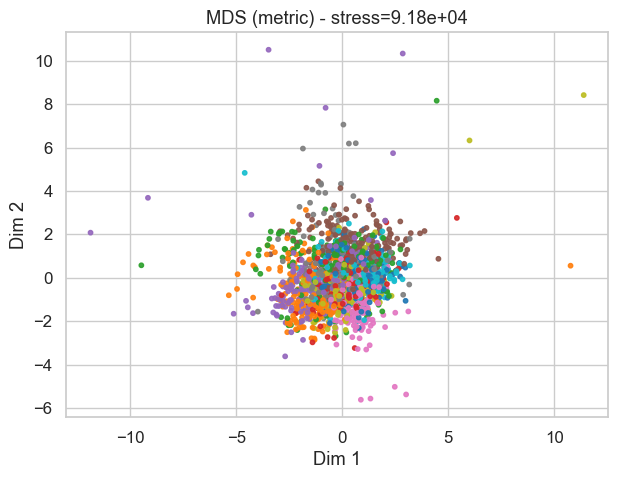

In [40]:
# Cell 4: MDS embedding and stress
# Metric MDS for 2D and check "stress"
# Note: MDS scales poorly for very large datasets; digits (1797) is moderately large

mds = MDS(n_components=31, metric=True, n_init=5, max_iter=500, random_state=101)
X_mds = mds.fit_transform(X_scaled)
stress = mds.stress_
print(f"MDS stress: {stress:.4f}")

plot_2d_embedding(X_mds, y, title=f"MDS (metric) - stress={stress:.2e}")
plt.show()

# Lower stress => embedding better preserves distances.
# For MDS, typical thresholds: stress < 0.1 is great, 0.1–0.2 acceptable; but scale depends on dissimilarities, so hard to judge based only on stress.
# Modifying parameters like n_init and max_iter increases time complexity further.


Running t-SNE: perp = 10 | lr = 200
  Completed in 4.19s | trust = 0.9817 | knn5 = 0.60 | knn31 = 0.55
Running t-SNE: perp = 10 | lr = 500
  Completed in 4.42s | trust = 0.9823 | knn5 = 0.60 | knn31 = 0.55
Running t-SNE: perp = 10 | lr = 1000
  Completed in 6.19s | trust = 0.9810 | knn5 = 0.60 | knn31 = 0.54
Running t-SNE: perp = 25 | lr = 200
  Completed in 5.30s | trust = 0.9840 | knn5 = 0.59 | knn31 = 0.58
Running t-SNE: perp = 25 | lr = 500
  Completed in 6.87s | trust = 0.9850 | knn5 = 0.59 | knn31 = 0.58
Running t-SNE: perp = 25 | lr = 1000
  Completed in 6.00s | trust = 0.9827 | knn5 = 0.59 | knn31 = 0.57
Running t-SNE: perp = 50 | lr = 200
  Completed in 7.74s | trust = 0.9844 | knn5 = 0.56 | knn31 = 0.59
Running t-SNE: perp = 50 | lr = 500
  Completed in 8.07s | trust = 0.9834 | knn5 = 0.56 | knn31 = 0.59
Running t-SNE: perp = 50 | lr = 1000
  Completed in 8.22s | trust = 0.9824 | knn5 = 0.56 | knn31 = 0.59
Best t-SNE by trustworthiness: perp = 25 | lr = 500


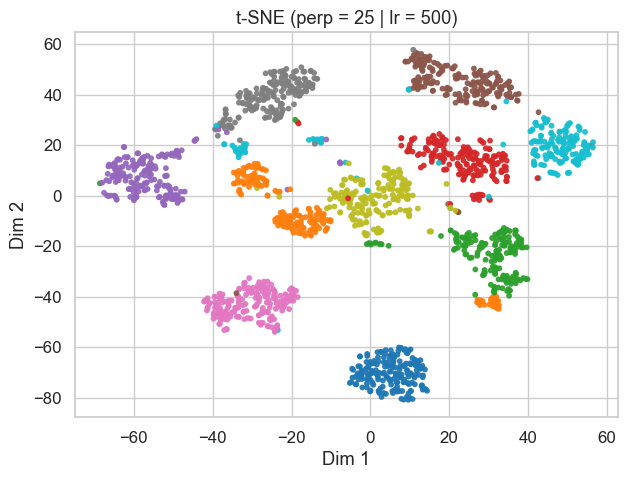

In [41]:
# Cell 5: t-SNE hyperparameter exploration
# Barnes-Hut t-SNE (method='barnes_hut') which is faster for n>1000.
# Tune perplexity and learning_rate
# Compute trustworthiness & KNN-preservation

from time import time

# hyperparameter exploration
perplexities = [10, 25, 50]
learning_rates = [200, 500, 1000]   # default 200 (sklearn)
tsne_results = {}

for perplexity in perplexities:
    for lr in learning_rates:
        key = f"perp = {perplexity} | lr = {lr}"
        print("Running t-SNE:", key)
        t0 = time()
        tsne = TSNE(
            n_components = 2,
            perplexity = perplexity,
            learning_rate = lr,
            n_iter = 1000,
            method = 'barnes_hut', # faster approximate algorithm for larger n compared to 'exact'
            random_state = 101,
            init = "pca",   # initialization
            verbose = 0
        )
        X_tsne = tsne.fit_transform(X_scaled)
        elapsed = time() - t0
        tr = compute_trust(X_scaled, X_tsne, n_neighbors=12)
        kp = knn_preservation_curve(X_scaled, X_tsne, ks=(5, 20, 31)) # 31 from PCA (90%)
        tsne_results[key] = {
            "X": X_tsne, "trust": tr, "knn_pres": kp, "time": elapsed, "perplexity": perplexity, "lr": lr
        }
        print(f"  Completed in {elapsed:.2f}s | trust = {tr:.4f} | knn5 = {kp[5]:.2f} | knn31 = {kp[31]:.2f}")

# Choose a best-looking config by trustworthiness (for visualization)
best_key = max(tsne_results.keys(), key=lambda k: tsne_results[k]['trust'])
print("Best t-SNE by trustworthiness:", best_key)
# Plot best
plot_2d_embedding(tsne_results[best_key]["X"], y, title=f"t-SNE ({best_key})")
plt.show()


UMAP neighbors = 10 | min dist = 0.0 | trust = 0.9681 | knn5 = 0.44 | knn31 = 0.54
UMAP neighbors = 10 | min dist = 0.05 | trust = 0.9691 | knn5 = 0.43 | knn31 = 0.54
UMAP neighbors = 10 | min dist = 0.1 | trust = 0.9693 | knn5 = 0.43 | knn31 = 0.55
UMAP neighbors = 10 | min dist = 0.2 | trust = 0.9693 | knn5 = 0.41 | knn31 = 0.55
UMAP neighbors = 20 | min dist = 0.0 | trust = 0.9716 | knn5 = 0.39 | knn31 = 0.55
UMAP neighbors = 20 | min dist = 0.05 | trust = 0.9721 | knn5 = 0.39 | knn31 = 0.56
UMAP neighbors = 20 | min dist = 0.1 | trust = 0.9705 | knn5 = 0.39 | knn31 = 0.55
UMAP neighbors = 20 | min dist = 0.2 | trust = 0.9706 | knn5 = 0.37 | knn31 = 0.56
UMAP neighbors = 25 | min dist = 0.0 | trust = 0.9700 | knn5 = 0.38 | knn31 = 0.55
UMAP neighbors = 25 | min dist = 0.05 | trust = 0.9718 | knn5 = 0.37 | knn31 = 0.56
UMAP neighbors = 25 | min dist = 0.1 | trust = 0.9690 | knn5 = 0.36 | knn31 = 0.55
UMAP neighbors = 25 | min dist = 0.2 | trust = 0.9719 | knn5 = 0.35 | knn31 = 0.56
U

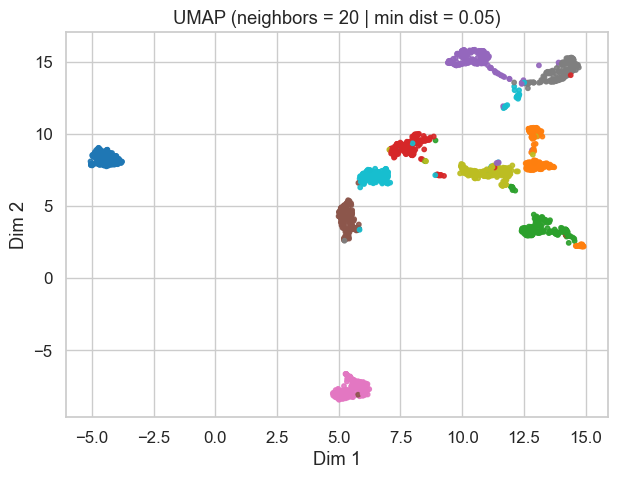

In [42]:
##### Cell 6: UMAP hyperparameter tuning
# UMAP tends to be faster and can preserve both local and some global structure
# Sweep n_neighbors and min_dist to see sensitivity (small grid)
umap_results = {}
n_neighbors_list = [10, 20, 25, 50] # controls the local neighborhood size (preservation: low for local, high for global)
min_dist_list = [0.0, 0.05, 0.1, 0.2] # controls how tightly UMAP packs points (small => denser clusters)

for n_neighbors in n_neighbors_list:
    for min_dist in min_dist_list:
        key = f"neighbors = {n_neighbors} | min dist = {min_dist}"
        reducer = umap.UMAP(n_components = 2, n_neighbors = n_neighbors, min_dist = min_dist, random_state = 101)
        X_umap = reducer.fit_transform(X_scaled)
        tr = compute_trust(X_scaled, X_umap, n_neighbors = 20)
        kp = knn_preservation_curve(X_scaled, X_umap, ks=(5, 20, 31))
        umap_results[key] = {"X": X_umap, "trust": tr, "knn_pres": kp, "n_neighbors": n_neighbors, "min_dist": min_dist}
        print(f"UMAP {key} | trust = {tr:.4f} | knn5 = {kp[5]:.2f} | knn31 = {kp[31]:.2f}")

#  Choose a best-looking config by trustworthiness (for visualization)
best_umap_key = max(umap_results.keys(), key=lambda k: umap_results[k]["trust"])
print("Best UMAP by trustworthiness:", best_umap_key)
plot_2d_embedding(umap_results[best_umap_key]["X"], y, title=f"UMAP ({best_umap_key})")
plt.show()


In [43]:
# Cell 7: Quantitative comparison across methods
# Compute a set of metrics for each method's chosen embedding:
#   - trustworthiness (k = 10 neighbors)
#   - knn-preservation at ks = {5, 20, 31}
#   - silhouette (rlabels to measure class compactness)
#   - KNN classification accuracy (stratified CV)
#   - Clustering metrics after KMeans (ARI, NMI) compared to true labels

from collections import OrderedDict
results = OrderedDict()

# Define embeddings to evaluate: PCA2, MDS, best t-SNE, best UMAP
embeddings = {
    "PCA2": X_pca2,
    "MDS": X_mds,
    "t-SNE": tsne_results[best_key]["X"],
    "UMAP": umap_results[best_umap_key]["X"],
}

for name, X_emb in embeddings.items():
    tr = compute_trust(X_scaled, X_emb, n_neighbors=10)
    kp = knn_preservation_curve(X_scaled, X_emb, ks=(5,20,31))
    sil = silhouette_score(X_emb, y)
    # KNN classifier (in embedding space)
    knn = KNeighborsClassifier(n_neighbors=5)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)
    knn_acc = np.mean(cross_val_score(knn, X_emb, y, cv=cv, scoring="accuracy"))
    # KMeans clustering
    kmeans = KMeans(n_clusters=10, random_state=101).fit(X_emb)
    labels_km = kmeans.labels_
    ari = adjusted_rand_score(y, labels_km)
    nmi = normalized_mutual_info_score(y, labels_km)
    results[name] = {
        "trust": tr,
        "knn5": kp[5],
        "knn20": kp[20],
        "knn31": kp[31],
        "silhouette": sil,
        "knn_acc": knn_acc,
        "ARI": ari,
        "NMI": nmi,
    }

# Display results in a DataFrame
df_results = pd.DataFrame(results).T
df_results = df_results[["trust", "knn5", "knn20", "knn31", "silhouette", "knn_acc", "ARI", "NMI"]]
df_results.style.background_gradient(cmap='Blues')
print(df_results)


          trust      knn5     knn20     knn31  silhouette   knn_acc       ARI  \
PCA2   0.816284  0.085364  0.175849  0.217441    0.054742  0.549246  0.327219   
MDS    0.998314  0.794213  0.863606  0.882564    0.115097  0.973288  0.458698   
t-SNE  0.986735  0.589093  0.570228  0.578132    0.500832  0.973852  0.877727   
UMAP   0.978841  0.393656  0.525876  0.556465    0.593849  0.976072  0.867531   

            NMI  
PCA2   0.463134  
MDS    0.616509  
t-SNE  0.899263  
UMAP   0.897015  


**Measures**:
- Trustworthiness: higher => embedding preserves local neighborhoods.
- KNN preservation: proportion (0–1) of preserved neighbors; returns direct neighborhood overlap.
- Silhouette: uses true class labels; higher means clearer class separation in embedding space.
- KNN accuracy: how well a simple classifier performs in embedding space (acts as proxy for label separability).
- ARI / NMI (KMeans): cluster quality vs true labels.

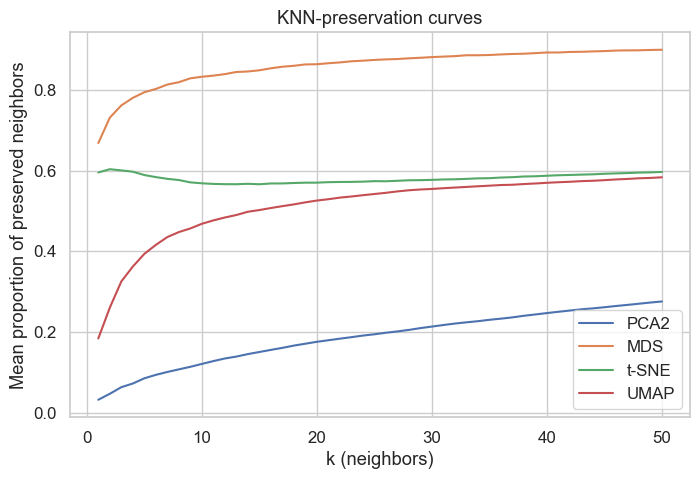

In [44]:
# Cell 8: KNN-preservation curves across k values
# Plot proportion of neighbors preserved for a range of k (1, ..., 50) for each method

ks = list(range(1,51))
pres_curves = {}
for name, X_emb in embeddings.items():
    vals = []
    for k in ks:
        vals.append(knn_preservation_curve(X_scaled, X_emb, ks=(k,))[k])
    pres_curves[name] = np.array(vals)

fig, ax = plt.subplots(figsize=(8,5))
for name, vals in pres_curves.items():
    ax.plot(ks, vals, label=name)
ax.set_xlabel("k (neighbors)")
ax.set_ylabel("Mean proportion of preserved neighbors")
ax.set_title("KNN-preservation curves")
ax.legend()
plt.show()


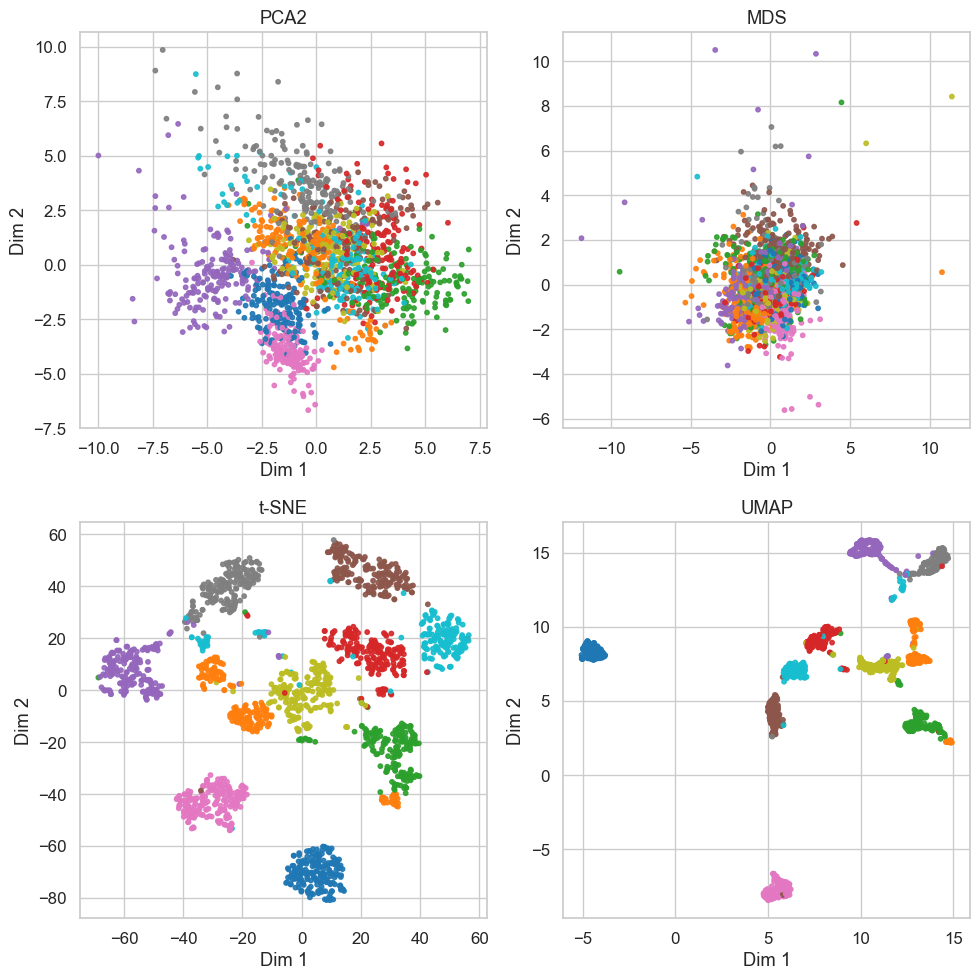

In [45]:
# Cell 9: Plots of the embeddings (clusters in 2D visualized)

fig, axes = plt.subplots(2,2, figsize=(10,10))
axes = axes.flatten()
for ax, (name, X_emb) in zip(axes, embeddings.items()):
    plot_2d_embedding(X_emb, y, title=name, ax=ax)
plt.tight_layout()
plt.show()


### Recommended hyperparameters
Summary of recommended settings:
- PCA: compute 31 components to retain ~90% variance, use PCA(n_components=2) only for baseline plotting.
- MDS: metric MDS is useful for preserving pairwise distances but can be slow; good for small/medium datasets.
- t-SNE: use method='barnes_hut' for n>1000; try perplexity in [5,30,50], learning_rate ~ 200; init='pca'; run a few seeds for consistency/comparison.
- UMAP: default n_neighbors=15 and min_dist=0.1 are good starting points; sweep n_neighbors (5, ..., 50) and min_dist (0.0, ..., 0.5).

From the quantitative metrics table, choose the method that fits your goal:
- For tight local clusters: t-SNE (but global distances aren't meaningful).
- For faster runs, reproducibility, and some global structure: UMAP.
- For linear baseline & dimensionality reduction before ML models: PCA.
- For faithful distance preservation: MDS (but slower). In particular, it persforms best in trust.